In [1]:
spark.version

'3.0.1'

In [2]:
import subprocess

from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [3]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [6]:
%%time

tweets = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/abharathsingh/covid_tweets')

CPU times: user 2.31 ms, sys: 693 µs, total: 3 ms
Wall time: 981 ms


In [7]:
tweets.printSchema()

root
 |-- created_at: string (nullable = true)
 |-- id: long (nullable = true)
 |-- user: struct (nullable = true)
 |    |-- contributors_enabled: boolean (nullable = true)
 |    |-- created_at: string (nullable = true)
 |    |-- default_profile: boolean (nullable = true)
 |    |-- default_profile_image: boolean (nullable = true)
 |    |-- description: string (nullable = true)
 |    |-- favourites_count: long (nullable = true)
 |    |-- follow_request_sent: string (nullable = true)
 |    |-- followers_count: long (nullable = true)
 |    |-- following: string (nullable = true)
 |    |-- friends_count: long (nullable = true)
 |    |-- geo_enabled: boolean (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- id_str: string (nullable = true)
 |    |-- is_translator: boolean (nullable = true)
 |    |-- lang: string (nullable = true)
 |    |-- listed_count: long (nullable = true)
 |    |-- location: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- notif

In [9]:
data_df = tweets

In [10]:
data_df2 = data_df.withColumn("Organization", 
                        f.when(data_df.verified_user == 'false', 'Other') \
                        .when((data_df.user_description.contains('health')) | (data_df.user_name.contains('health')) \
                              | (data_df.user_description.contains('medic')) | (data_df.user_name.contains('medic')) \
                              | (data_df.user_description.contains('clinic')) | (data_df.user_name.contains('clinic')) \
                              | (data_df.user_description.contains('nurse')) | (data_df.user_name.contains('nurse')) \
                              | (data_df.user_description.contains('doctor')) | (data_df.user_name.contains('doctor')) \
                              | (data_df.user_description.contains('hospital')) | (data_df.user_name.contains('hospital')) \
                              | (data_df.user_description.contains('disease')) | (data_df.user_name.contains('disease')), 'Health') \
                        .when((data_df.user_description.contains('gov')) | (data_df.user_name.contains('gov')) \
                              | (data_df.user_description.contains('president')) | (data_df.user_name.contains('president')) \
                              | (data_df.user_description.contains('senat')) | (data_df.user_name.contains('senat')) \
                              | (data_df.user_description.contains('congress')) | (data_df.user_name.contains('congress')) \
                              | (data_df.user_description.contains('prime minister')) | (data_df.user_name.contains('prime minister')) \
                              | (data_df.user_description.contains('parliament')) | (data_df.user_name.contains('parliament')) \
                              | (data_df.user_description.contains('vp')) | (data_df.user_name.contains('vp')) \
                              | (data_df.user_description.contains('white house')) | (data_df.user_name.contains('white house')) \
                              | (data_df.user_description.contains('mayor')) | (data_df.user_name.contains('mayor')) \
                              | (data_df.user_description.contains('democr')) | (data_df.user_name.contains('democr')) \
                              | (data_df.user_description.contains('republic')) | (data_df.user_name.contains('republic')), 'Government') \
                        .when((data_df.user_description.contains('news')) | (data_df.user_name.contains('news')) \
                              | (data_df.user_description.contains('daily')) | (data_df.user_name.contains('daily')) \
                              | (data_df.user_description.contains('times')) | (data_df.user_name.contains('times')) \
                              | (data_df.user_description.contains('journal')) | (data_df.user_name.contains('journal')), 'News') \
                        .when(((data_df.user_description.contains('actor')) & (data_df.followers_count > 30000)) \
                              | ((data_df.user_description.contains('singer')) & (data_df.followers_count > 30000)) \
                              | ((data_df.user_description.contains('writer')) & (data_df.followers_count > 30000)) \
                              | ((data_df.user_description.contains('play')) & (data_df.followers_count > 30000)) \
                              | ((data_df.user_description.contains('musician')) & (data_df.followers_count > 30000)) \
                              | ((data_df.user_description.contains('actress')) & (data_df.followers_count > 30000)) \
                              | ((data_df.user_description.contains('golfer')) & (data_df.followers_count > 30000)) \
                              | ((data_df.user_description.contains('author')) & (data_df.followers_count > 30000)), 'Celebrity') \
                        .when(data_df.followers_count >= 10000, 'Influencer')) 

In [11]:
data_df2 = data_df2.na.fill(value='Other',subset=["Organization"])

In [13]:
time = data_df2.select(['id','created_at'])

In [14]:
from pyspark.sql.functions import split

In [17]:
time1 = time.withColumn('weekday', split(time['created_at'], ' ').getItem(0)) \
            .withColumn('month', split(time['created_at'], ' ').getItem(1)) \
            .withColumn('day', split(time['created_at'], ' ').getItem(2)) \
            .withColumn('time', split(time['created_at'], ' ').getItem(3)) \
            .withColumn('0000', split(time['created_at'], ' ').getItem(4)) \
            .withColumn('year', split(time['created_at'], ' ').getItem(5))

In [19]:
#time1

In [20]:
time2 = time1.withColumn("month_number",from_unixtime(unix_timestamp(col("month"),'MMM'),'MM'))

In [22]:
#time2

In [23]:
time3 = time2.withColumn("merge", concat_ws("-", "month_number", "day", "year")) \
  .withColumn("date", to_date(unix_timestamp("merge", "MM-dd-yyyy").cast("timestamp"))).drop("merge")

In [25]:
#time3

In [26]:
time4 = time3.drop("created_at")\
        .drop("weekday")\
        .drop("month")\
        .drop("day")\
        .drop("time")\
        .drop("0000")\
        .drop("year")\
        .drop("month_number")

In [27]:
time4

id,date
1455748233184092160,2021-11-03
1455748233595166723,2021-11-03
1455748233876099072,2021-11-03
1455748236740907012,2021-11-03
1455748237642641410,2021-11-03
1455748238036783107,2021-11-03
1455748239127420928,2021-11-03
1455748240310210560,2021-11-03
1455748241245437957,2021-11-03
1455748241321041922,2021-11-03


In [29]:
time4.count()

13672943

In [31]:
time5 = time4.dropDuplicates(['id'])

In [32]:
joined_df = data_df2.join(time5, "id", "left")

In [35]:
timesseries = joined_df.select(["date", "Organization"]).groupBy("Organization", "date").count()

In [36]:
timesseries

Organization,date,count
Celebrity,2021-10-27,391
Influencer,2021-11-04,3967
Celebrity,2021-10-31,246
Health,2021-11-05,2775
Government,2021-11-07,670
News,2021-10-26,9193
Influencer,2021-10-18,4854
Health,2021-10-26,2631
Influencer,2021-11-11,2964
Other,2021-10-23,391809


In [50]:
timesseriess = timesseries.filter(timesseries.Organization != "Other")

In [51]:
timesseriess

Organization,date,count
Celebrity,2021-10-27,391
Influencer,2021-11-04,3967
Celebrity,2021-10-31,246
Health,2021-11-05,2775
Government,2021-11-07,670
News,2021-10-26,9193
Influencer,2021-10-18,4854
Health,2021-10-26,2631
Influencer,2021-11-11,2964
Health,2021-10-21,2714


In [54]:
p_timesseries = timesseriess.toPandas()

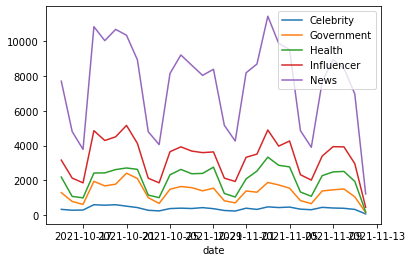

In [55]:
from matplotlib import pyplot as plt 

fig, ax = plt.subplots()
for label, grp in p_timesseries.groupby('Organization'):
    grp.plot(x = 'date', y = 'count',ax = ax, label = label)

In [41]:
timesseries2 = joined_df.select(["date"]).groupBy("date").count()

In [42]:
timesseries2

date,count
2021-11-11,419275
2021-11-01,474290
2021-10-20,643289
2021-11-05,538470
2021-10-18,700906
2021-11-07,416667
2021-10-22,524895
2021-10-23,401189
2021-10-29,459519
2021-11-10,494601


In [43]:
p_timesseries2 = timesseries2.toPandas()

NameError: name 'plt' is not defined

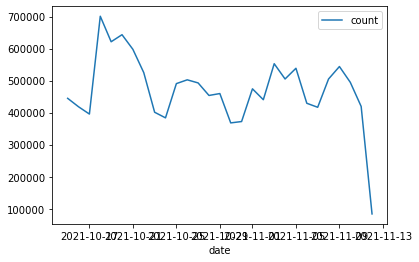

In [44]:
p_timesseries2.plot(kind='line', x='date', y='count')
plt.show()